In [3]:
import warnings
import copy

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from Functions import pmfg
import seaborn as sns
import networkx as nx


warnings.filterwarnings('ignore')
%matplotlib inline


df = pd.read_excel("Credit risk exposures and exposures to sovereigns a.xlsx", header=1, index_col=0)
df = df.iloc[:, 0:8]
df = df.drop("4. Total retail", axis = 1)
df.columns = ["1_Sov", "2_Fin", "3_Corp", "4-1_Ret_Res", "4-2_Ret_Rev", "4-3_Ret_SME", "5_CRE"]

sd_df = pd.read_excel("EU_SOV_Debt_Bank_Net_2011.xlsx", header=0, index_col=0)
sd_df.index = sd_df.index.rename("SD_Name")
sd_names = [sd.encode('ascii', 'ignore') for sd in sd_df.index]
sd_names_prefix = ["1_Sov_" + sd for sd in sd_names]
sd_df = sd_df.T

cap_df = pd.read_excel("Tier-1 CRs 2010.xlsx", header=2, index_col=1).iloc[:, 1].to_frame("Capital")

df = pd.merge(sd_df, df, left_index=True, right_index=True).rename(columns={"1_Sov":"1b_Sov"})
df = pd.merge(df, cap_df, left_index=True, right_index=True).applymap(np.float)
df.loc[:, "1b_Sov"] = df.loc[:, "1b_Sov"] - df.loc[:, sd_names].apply(np.sum, axis=1)
df.loc[:, "1b_Sov"] = np.maximum(df.loc[:, "1b_Sov"], 0.)

In [147]:
ScenarioSet = False

def overlap(x1, x2):
    return x1.dot(x2) / np.sqrt(x1.dot(x1) * x2.dot(x2))


def getRiskWeights(minmax):
    if minmax == "min":
        return {"1": 0.002, "1b": 0.002, "2": 0.5, "3": 0.7, "4-1": 0.4, "4-2": 0.8, "4-3": 1, "5": 1}
    elif minmax == "max":
        return {"1": 0.1, "1b": 0.1, "2": 1, "3": 1.3, "4-1": 0.8, "4-2": 1.2, "4-3": 1.3, "5": 2}
    else:
        # In case of input error, return minimum weights.
        return {"1": 0.002, "1b": 0.002, "2": 0.5, "3": 0.7, "4-1": 0.4, "4-2": 0.8, "4-3": 1, "5": 1}

    
def BankSnap(time, enhancement):
    if enhancement == False:
        timesteps[time].setBankSnap([[bank, banks[bank].getCapital(), banks[bank].getRWA()] for bank in banks])
    else:
        banksnap = []
        for bank in banks:
            df = pd.DataFrame([[asset, assets[asset].getCrisisLevel()] for asset in sd_names], 
                              columns=["asset", "crisislevel"]).set_index("asset")

            crisislevel = banks[bank].getGeoStructure().dot(df)
            for asset in list(set([asset for asset in assets])-set(sd_names)):
                obj = assets[asset]
                obj.setRiskWeight(crisislevel*obj.getRiskWeight())

            rwa = banks[bank].getRWA()

            for asset in list(set([asset for asset in assets])-set(sd_names)):
                obj = assets[asset]
                obj.setRiskWeight(obj.getStaticRiskWeight())

            banksnap.append([bank, banks[bank].getCapital(), rwa])

        timesteps[time].setBankSnap(banksnap)
    

def AssetSnap(time):
    timesteps[time].setAssetSnap([[asset, assets[asset].getValue(), assets[asset].getRiskWeight()] for asset in sd_names])

def RiskUpdate(time):
    delta_R = timesteps[time-1].getBankSnap().loc[:, "R"] / timesteps[time-2].getBankSnap().loc[:, "R"]
    omega_s = 1 - Q(100) + Q(100)*(world.getSD().T.dot(P(delta_R))/(world.getSD().apply(np.sum)))

    for asset in omega_s.index:
        obj = assets[asset]
        obj.setRiskWeight(obj.getRiskWeight()/omega_s.loc[asset])
        
    
def InitScenario(minmax):
    DelScenario()
    riskweights = getRiskWeights(minmax)
    for asset in assets:
        obj = assets[asset]
        obj.setRiskWeight(riskweights[obj.getAssetClass()])
        obj.setStaticRiskWeight(riskweights[obj.getAssetClass()])
            
    for bank in banks:
        obj = banks[bank]
        obj.setCapital(obj.getCapital()*obj.getRWA())
        
    return True
        
        
def DelScenario():
    for asset in df.drop("Capital", axis=1).columns:
        obj = assets[asset]
        obj.setRiskWeight(None)
    for bank in banks:
        obj = banks[bank]
        obj.setCapital(df.ix[bank, -1])
    
    return False
    
        
def Shock(shocklist, shockfactor):
    if ScenarioSet:
        for asset in assets:
            if asset in shocklist:
                obj = assets[asset]
                obj.setRiskWeight(shockfactor*obj.getRiskWeight())
                obj.shock(True)
    else:
        print "Error. Set Scenario first."
        
def P(x):
    return np.minimum(0.1 + 0.9*x, 1)

def Q(x):
    return 1. - 2**(-x/100.)

class World(object):
    def __init__(self, structure):
        self._structure = structure
    
    def getAll(self):
        return self._structure
    
    def getSD(self):
        return self._structure.loc[:, sd_names]

        
class Bank(object):
    # Initialize with name, country, holdings and capital ratio (since this is what we know)
    # When the stress test scenario is initialized, the capital is updated using the ratio and the RWA.
    def __init__(self, name, country, holdings, capital):
        self._name = name
        self._country = country
        self._holdings = holdings
        self._capital = capital
        
    def getName(self):
        return self._name
    
    def setName(self, n):
        self._name = n
    
    def getCountry(self):
        return self._country
    
    def setCountry(self, c):
        self._country = c
    
    def getHoldings(self):
        df = self._holdings.to_frame("value")
        df.loc[:, "class"] = [assets[asset].getAssetClass() for asset in df.index.values]
        return df
    
    def setHoldings(self, h):
        self._holdings = h
    
    def getCapital(self):
        return self._capital
    
    def setCapital(self, c):
        self._capital = c
        
    def getRWA(self):
        holdings = self.getHoldings().loc[:, "value"]
        return np.sum([holdings.loc[asset]*assets[asset].getRiskWeight() for asset in holdings.index])
    
    def getGeoStructure(self):
        df = self.getHoldings()
        df = df.loc[df["class"]=='1', "value"]
        return df/np.sum(df)
    
    def getInitialExposure(self):
        df = self.getHoldings()
        return np.sum(df.loc[[assets[asset].isShocked() for asset in sd_names], "value"]) / np.sum(df.loc[sd_names, "value"])
            
        
    name = property(getName, setName)
    country = property(getCountry, setCountry)
    holdings = property(getHoldings, setHoldings)
    capital = property(getCapital, setCapital)
    
    def getOverlap(self, other):
        return overlap(self.getHoldings(), other.getHoldings())
    
    def __str__(self):
        return '{}, from {}'.format(self.name, self.country)

    
class Asset(object):
    def __init__(self, asset_class, name, value, holders, riskweight=None):
        self._asset_class = asset_class
        self._name = name
        self._value = value
        self._holders = holders
        self._riskweight = riskweight
        self._staticriskweight = riskweight
        
    def getName(self):
        return self._name
    
    def getAssetClass(self):
        return self._asset_class
    
    def getValue(self):
        return self._value
    
    def getHolders(self):
        return self._holders
    
    def getRiskWeight(self):
        return self._riskweight
    
    def setRiskWeight(self, r):
        self._riskweight = r

    def getStaticRiskWeight(self):
        return self._staticriskweight
        
    def setStaticRiskWeight(self, r):
        self._staticriskweight = r
        
    riskweight = property(getRiskWeight, setRiskWeight)
    staticriskweight = property(getStaticRiskWeight, setStaticRiskWeight)    
    
    def getOverlap(self, other):
        return overlap(self.getValue()*self.getHolders(), other.getValue()*other.getHolders())
    
    def __str__(self):
        return '{}, class {}, total value of {}, risk-weight {}'.format(self._name, self._asset_class, np.round(self._value, 0), self.riskweight)
        
        
class SovereignDebt(Asset):
    def __init__(self, name, value, holders, riskweight=None, shocked=False):
        Asset.__init__(self, "1", name, value, holders, riskweight=None)
        self._shocked = shocked
    
    def getCountry(self):
        return self._country
    
    def isShocked(self):
        return self._shocked
    
    def shock(self, s):
        self._shocked = s
        
    def getCrisisLevel(self):
        return np.minimum(self._riskweight/self._staticriskweight, 1.5)
    
            
class PrivateDebt(Asset):
    def __init__(self,asset_class, name, value, holders, riskweight=None):
        Asset.__init__(self, asset_class, name, value, holders, riskweight=None)
        
    def isShocked(self):
        return False
    
    def getCrisisLevel(self):
        return 1.
        
        
        
class Snapshot(object):
    def __init__(self, time):
        self._time = time
        self._banks = None
        self._assets = None
        
    def getTime(self):
        return self._time
        
    def getBankSnap(self):
        return self._banks
    
    def setBankSnap(self, data):
        df = pd.DataFrame(data=data, columns=["bank", "C", "W"]).set_index("bank").sort_index()
        df.loc[:, "R"] = df.loc[:, "C"]/df.loc[:, "W"]
        self._banks = df
        
    def getAssetSnap(self):
        return self._assets
    
    def setAssetSnap(self, data):
        df = pd.DataFrame(data=data, columns=["asset", "value", "weight"]).set_index("asset").sort_index()
        self._assets = df

    banks = property(getBankSnap, setBankSnap)
    assets = property(getAssetSnap, setAssetSnap)

    
banks = {}
for bank in df.index:
    banks[bank] = Bank(bank, bank[0:2], df.ix[bank, :-1], df.ix[bank, -1])
    
assets = {}
for asset in df.iloc[:, :-1].columns:
    if asset in sd_names:
        assets[asset] = SovereignDebt(asset, np.sum(df.loc[:, asset]), df.loc[:, asset]/np.sum(df.loc[:, asset]), None, False)
    else:
        asset_class = asset[:asset.find("_")]
        assets[asset] = PrivateDebt(asset_class, asset, np.sum(df.loc[:, asset]), df.loc[:, asset]/np.sum(df.loc[:, asset]), None)

        

In [148]:
timesteps = {}
world = World(df)
enhancement = False

for time in range(0,20):
    timesteps[time] = Snapshot(time)
    
    if time == 0:
        ScenarioSet = InitScenario("min")
        BankSnap(time, enhancement)
        AssetSnap(time)
        
    elif time == 1:
        Shock(["DE", "FR", "GB"], 10)
        BankSnap(time, enhancement)
        AssetSnap(time)
        
    elif np.mod(time,2) == 0:
        BankSnap(time, enhancement)
        RiskUpdate(time)
        AssetSnap(time)
        
    else:
        BankSnap(time, enhancement)
        AssetSnap(time)
        

                  C              W      R
bank                                     
AT001   9946.277940  114325.033788  0.087
AT002   6316.739320   77984.436055  0.081
AT003   1526.484415   23851.318992  0.064
BE004  23316.612348  192699.275600  0.121
BE005  11141.775009  106112.142942  0.105
                  C              W         R
bank                                        
AT001   9946.277940  114345.693728  0.086984
AT002   6316.739320   77996.100342  0.080988
AT003   1526.484415   23852.391987  0.063997
BE004  23316.612348  192960.283211  0.120836
BE005  11141.775009  106168.526547  0.104944


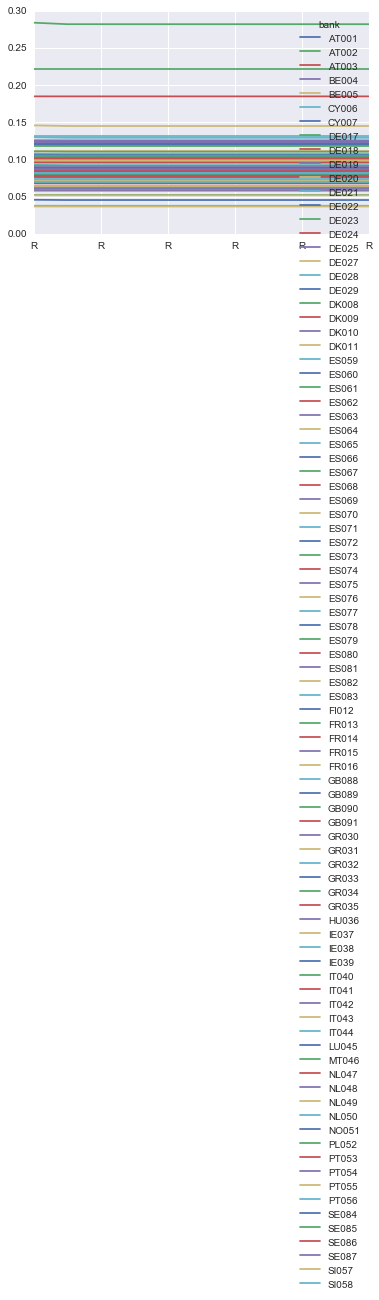

In [149]:
print timesteps[0].getBankSnap().head()
print timesteps[1].getBankSnap().head()
banks_df = pd.concat([timesteps[0].getBankSnap().loc[:, "R"], timesteps[1].getBankSnap().loc[:, "R"]], axis=1)
for t in range(3,20,2):
    #print timesteps[t].getBankSnap().head()
    banks_df = pd.concat([banks_df, timesteps[t].getBankSnap().loc[:, "R"]], axis=1)
    
banks_df.T.plot()
    


In [150]:
print timesteps[0].getAssetSnap().head()
for t in range(1,20,2):
    print timesteps[t].getAssetSnap().head()

              value  weight
asset                      
AT     42420.496007   0.002
BE     90471.633340   0.002
BG      1845.151329   0.002
CY      2347.477392   0.002
CZ     25635.981796   0.002
              value  weight
asset                      
AT     42420.496007   0.002
BE     90471.633340   0.002
BG      1845.151329   0.002
CY      2347.477392   0.002
CZ     25635.981796   0.002
              value    weight
asset                        
AT     42420.496007  0.002002
BE     90471.633340  0.002001
BG      1845.151329  0.002001
CY      2347.477392  0.002001
CZ     25635.981796  0.002001
              value    weight
asset                        
AT     42420.496007  0.002002
BE     90471.633340  0.002001
BG      1845.151329  0.002001
CY      2347.477392  0.002001
CZ     25635.981796  0.002001
              value    weight
asset                        
AT     42420.496007  0.002002
BE     90471.633340  0.002001
BG      1845.151329  0.002001
CY      2347.477392  0.002001
CZ     2

In [139]:
print assets["DE"]

DE, class 1, total value of 488779.0, risk-weight 0.227975075422


In [151]:
print banks["DE023"]

DE023, from DE
